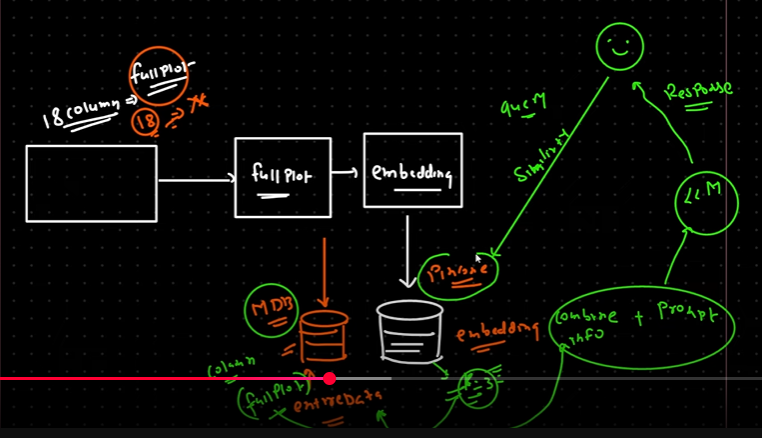

In [1]:
from datasets import load_dataset

d:\a27_YEARS_OLD\multimodal_rag\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset=load_dataset("MongoDB/embedded_movies")

In [3]:

import pandas as pd
data=pd.DataFrame(dataset["train"][:10])  # 
# data=data.sample(100)

In [4]:
data=data.dropna(subset=["fullplot"])

In [5]:
data=data.drop(columns=["plot_embedding"])

In [6]:
document=data.to_dict("records")

In [7]:
import os
from dotenv import load_dotenv
load_dotenv()
mongo_uri = os.getenv('MONGO_ATLAS_URI')
pinecone_api_key = os.getenv('PINECONE_API_KEY')

In [8]:
from pymongo.mongo_client import MongoClient
client = MongoClient(mongo_uri)
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


In [9]:
db=client["genai"]

In [10]:
collection=db["movies"] # no collection shows in atlas until atleast 1 data is added

In [12]:
collection.insert_many(document)

InsertManyResult([ObjectId('67813db7e63bc6d6bebe6e28'), ObjectId('67813db7e63bc6d6bebe6e29'), ObjectId('67813db7e63bc6d6bebe6e2a'), ObjectId('67813db7e63bc6d6bebe6e2b'), ObjectId('67813db7e63bc6d6bebe6e2c'), ObjectId('67813db7e63bc6d6bebe6e2d'), ObjectId('67813db7e63bc6d6bebe6e2e'), ObjectId('67813db7e63bc6d6bebe6e2f'), ObjectId('67813db7e63bc6d6bebe6e30'), ObjectId('67813db7e63bc6d6bebe6e31')], acknowledged=True)

In [13]:
from pinecone import Pinecone, ServerlessSpec

In [14]:
pc = Pinecone(api_key=pinecone_api_key)

In [16]:
index_name = 'mongo'

In [17]:
index = pc.Index(index_name)

In [18]:

from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("thenlper/gte-large")

In [19]:

def get_result(query,similar_result=3):
  embedding=embedding_model.encode(query)
  embedding=embedding.tolist()

  result=index.query(
    vector=embedding,
    top_k=similar_result,
  )
  return result

In [20]:
query="what is the best horror movie to watch and why?"

In [21]:
result=get_result(query)

In [22]:
result

{'matches': [{'id': '67813db7e63bc6d6bebe6e2f',
              'score': 0.733390331,
              'values': []},
             {'id': '67813db7e63bc6d6bebe6e2e',
              'score': 0.728455544,
              'values': []},
             {'id': '67813db7e63bc6d6bebe6e2a',
              'score': 0.724587202,
              'values': []}],
 'namespace': '',
 'usage': {'read_units': 5}}

In [23]:
from bson.objectid import ObjectId

In [24]:
mylist=[]
for i in  range(len(result["matches"])):
  value=result["matches"][i]['id']
  mylist.append(collection.find_one({"_id": ObjectId(value)}))

In [25]:
mylist

[{'_id': ObjectId('67813db7e63bc6d6bebe6e2f'),
  'plot': 'An ambitious and near insanely violent gangster climbs the ladder of success in the mob, but his weaknesses prove to be his downfall.',
  'runtime': 93,
  'genres': ['Action', 'Crime', 'Drama'],
  'fullplot': "Johnny Lovo rises to the head of the bootlegging crime syndicate on the south side of Chicago following the murder of former head, Big Louis Costillo. Johnny contracted Big Louis' bodyguard, Tony Camonte, to make the hit on his boss. Tony becomes Johnny's second in command. Johnny is not averse to killing anyone who gets in his and Johnny's way. As Tony is thinking bigger than Johnny and is not afraid of anyone or anything, Tony increasingly makes decisions on his own instead of following Johnny's orders, especially in not treading on the north side run by an Irish gang led by a man named O'Hara, of whom Johnny is afraid. Tony's murder spree increases, he taking out anyone who stands in his and Johnny's way of absolute con

In [26]:
combined_information = ""
for i in range(len(mylist)):
  fullplot=mylist[i]["fullplot"]
  title=mylist[i]["title"]
  combined_information += f"Title:{title}, fullplot: {fullplot}\n"

In [27]:
print(combined_information)

Title:Scarface, fullplot: Johnny Lovo rises to the head of the bootlegging crime syndicate on the south side of Chicago following the murder of former head, Big Louis Costillo. Johnny contracted Big Louis' bodyguard, Tony Camonte, to make the hit on his boss. Tony becomes Johnny's second in command. Johnny is not averse to killing anyone who gets in his and Johnny's way. As Tony is thinking bigger than Johnny and is not afraid of anyone or anything, Tony increasingly makes decisions on his own instead of following Johnny's orders, especially in not treading on the north side run by an Irish gang led by a man named O'Hara, of whom Johnny is afraid. Tony's murder spree increases, he taking out anyone who stands in his and Johnny's way of absolute control on the south side, and in Tony's view absolute control of the entire city. Tony's actions place an unspoken strain between Tony and Johnny to the point of the two knowing that they can't exist in their idealized world with the other. Ton

In [28]:
query

'what is the best horror movie to watch and why?'

In [29]:
prompt = f"Query: {query}\nContinue to answer the query by using the fullplot only:\n{combined_information}."

In [30]:
print(prompt)

Query: what is the best horror movie to watch and why?
Continue to answer the query by using the fullplot only:
Title:Scarface, fullplot: Johnny Lovo rises to the head of the bootlegging crime syndicate on the south side of Chicago following the murder of former head, Big Louis Costillo. Johnny contracted Big Louis' bodyguard, Tony Camonte, to make the hit on his boss. Tony becomes Johnny's second in command. Johnny is not averse to killing anyone who gets in his and Johnny's way. As Tony is thinking bigger than Johnny and is not afraid of anyone or anything, Tony increasingly makes decisions on his own instead of following Johnny's orders, especially in not treading on the north side run by an Irish gang led by a man named O'Hara, of whom Johnny is afraid. Tony's murder spree increases, he taking out anyone who stands in his and Johnny's way of absolute control on the south side, and in Tony's view absolute control of the entire city. Tony's actions place an unspoken strain between To

In [31]:
import os
from dotenv import load_dotenv
load_dotenv()
GOOGLE_API_KEY=os.getenv('GEMINI_API_KEY')
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [32]:

from langchain_google_genai import ChatGoogleGenerativeAI
def load_model(model_name):
  if model_name=="gemini-pro":
    llm = ChatGoogleGenerativeAI(model="gemini-pro")
  else:
    llm=ChatGoogleGenerativeAI(model="gemini-1.5-flash")

  return llm

In [33]:
model_text=load_model("gemini-pro")

In [39]:
model_text.invoke(prompt).content

'The provided information does not contain any horror movies, so I cannot answer the query.'